### Fama French 5 Factor Model

$$R_{i,t} - R_{f,t} = \alpha + \beta_{i, \mathrm{MKT}}(r_{m,t} - r_{f,t}) + \beta_{i, \mathrm{SMB}}\mathrm{SMB}_t + \beta_{i, \mathrm{HML}}\mathrm{HML}_t + \beta_{i, \mathrm{RMW}}\mathrm{RMW}_t + \beta_{i, \mathrm{CMA}}\mathrm{CMA}_t + \epsilon_{i, t}$$

- $R_{i,t}$ : 종목 i의 수익률
- $R_{f,t}$ : 무위험 수익률
- $r_{m,t}$ : 시장 수익률
- $\mathrm{SMB}_t$ : Small Minus Big
- $\mathrm{HML}_t$ : High Minus Low
- $\mathrm{RMW}_t$ : Robust Minus Weak
- $\mathrm{CMA}_t$ : Conservative Minus Aggressive


In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

factors = pd.read_csv('5factor_daily.CSV', index_col = 0)
factors.index = pd.to_datetime(factors.index.astype(str))
factors = factors/100
factors = factors['2008-01-01':]

In [2]:
import yfinance as yf
start = '2007-12-31'
end = '2024-01-01'

ticker = 'IBM'
data = yf.download(ticker, start = start, end = end).Close
data = np.log(data / data.shift(1)).dropna()['2008-01-01':]

[*********************100%%**********************]  1 of 1 completed


In [3]:
excess_return = data - factors['RF']

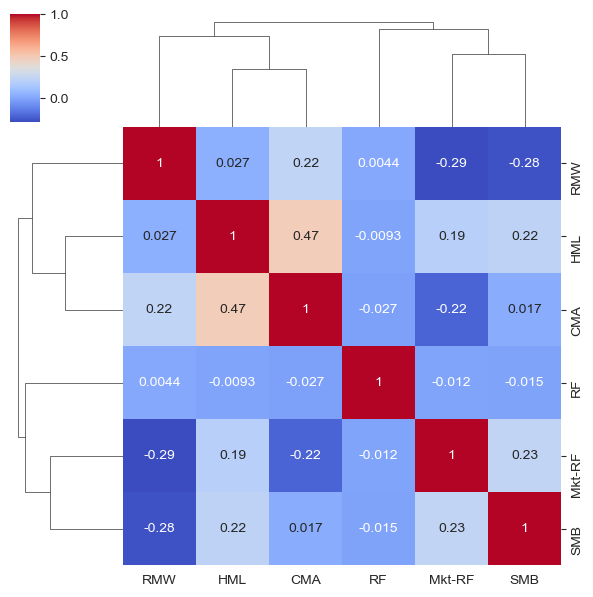

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

sns.clustermap(
    factors.corr(), 
    annot = True, 
    cmap = 'coolwarm', 
    figsize = (6, 6),
)

독립성 검정을 위해 공분산을 확인한다

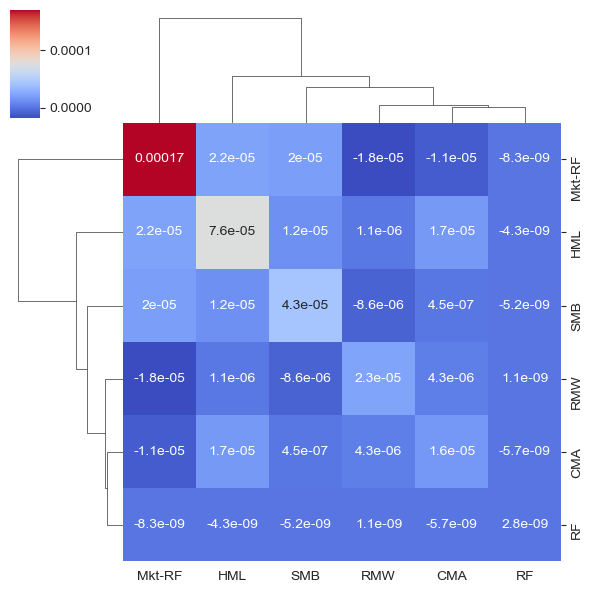

In [5]:
sns.clustermap(
    factors.cov(), 
    annot = True, 
    cmap = 'coolwarm', 
    figsize = (6, 6),
)

비선형적 관계까지 검정을 하기 위해서 Variation Information과 Mutual Information을 확인한다

In [6]:
import scipy.stats as ss
from sklearn.metrics import mutual_info_score

def numBins(nObs, corr = None) :
    if corr is None :
        z = (8 + 324 * nObs + 12 * (36 * nObs + 729 * nObs ** 2) ** 0.5) ** (1/3)
        b = round(z / 6 + 2 / (3 * z) + 1 / 3)
    else :
        b = round(2 ** 0.5 * (1 + (1 + 24 * nObs * (1 - corr ** 2)) ** 0.5) ** 0.5)
    return int(b)

def varInfo(x, y, norm = False) :
    b_xy = numBins(x.shape[0], corr = np.corrcoef(x, y)[0, 1])
    c_xy = np.histogram2d(x, y, b_xy)[0]
    i_xy = mutual_info_score(None, None, contingency = c_xy)
    h_x = ss.entropy(np.histogram(x, b_xy)[0])
    h_y = ss.entropy(np.histogram(y, b_xy)[0])
    v_xy = h_x + h_y - i_xy
    if norm :
        h_xy = h_x + h_y - i_xy
        v_xy /= h_xy
    return v_xy

In [7]:
def getVarInfoMatrix(data):
    vi = np.zeros((data.shape[1], data.shape[1]))
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            vi[i, j] = varInfo(data.iloc[:, i], data.iloc[:, j])
    vi = pd.DataFrame(vi, index = data.columns, columns = data.columns)
    return vi

In [8]:
vi = getVarInfoMatrix(factors)
vi

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,0.606576,3.401443,3.470429,3.377758,3.595981,3.520383
SMB,3.401443,0.431628,3.692591,3.627105,3.829161,3.746106
HML,3.470429,3.692591,0.334955,3.742888,3.530862,3.796868
RMW,3.377758,3.627105,3.742888,0.225859,3.867467,3.815116
CMA,3.595981,3.829161,3.530862,3.867467,0.639009,3.879274
RF,3.520383,3.746106,3.796868,3.815116,3.879274,0.284697


Text(0.5, 1.0, 'Variational Information')

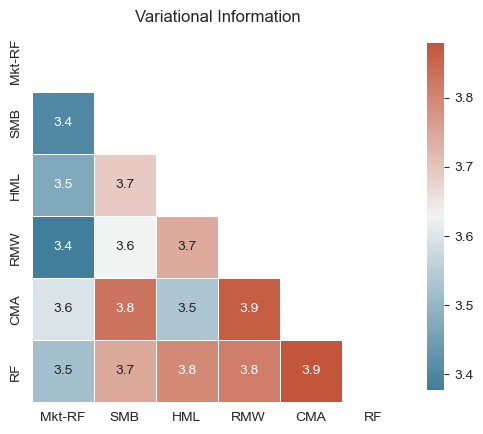

In [9]:
mask = np.triu(np.ones_like(vi, dtype = bool))
f, ax = plt.subplots(figsize = (6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(False)
sns.heatmap(vi, mask = mask, cmap = cmap,
            square = True, linewidths = .5, cbar_kws = {"shrink": .9}, annot = True)
plt.title('Variational Information')

In [10]:
def mutualInfo(x, y, norm = False) :
    b_xy = numBins(x.shape[0], corr = np.corrcoef(x, y)[0, 1])
    c_xy = np.histogram2d(x, y, b_xy)[0]
    i_xy = mutual_info_score(None, None, contingency = c_xy)
    if norm :
        h_x = ss.entropy(np.histogram(x, b_xy)[0])
        h_y = ss.entropy(np.histogram(y, b_xy)[0])
        i_xy /= (h_x + h_y)
    return i_xy

In [11]:
def getMutualInfoMatrix(data) :
    mi = np.zeros((data.shape[1], data.shape[1]))
    for i in range(data.shape[1]) :
        for j in range(data.shape[1]) :
            mi[i, j] = mutualInfo(data.iloc[:, i], data.iloc[:, j])
    mi = pd.DataFrame(mi, index = data.columns, columns = data.columns)
    return mi

In [12]:
mi = getMutualInfoMatrix(factors)
mi

,Mkt-RF,SMB,HML,RMW,CMA,RF
Mkt-RF,0.606576,0.098585,0.089605,0.096810,0.064506,0.046672
SMB,0.098585,0.431628,0.081179,0.086982,0.045063,0.034685
HML,0.089605,0.081179,0.334955,0.104830,0.232288,0.043929
RMW,0.096810,0.086982,0.104830,0.225859,0.080704,0.039622
CMA,0.064506,0.045063,0.232288,0.080704,0.639009,0.061976
RF,0.046672,0.034685,0.043929,0.039622,0.061976,0.284697


Text(0.5, 1.0, 'Mutual Information')

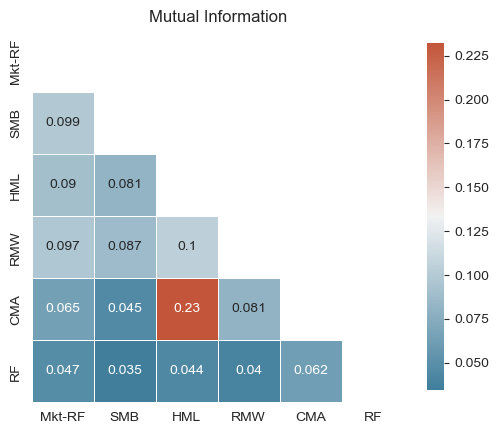

In [13]:
mask = np.triu(np.ones_like(mi, dtype = bool))
f, ax = plt.subplots(figsize = (6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
plt.grid(False)
sns.heatmap(mi, mask = mask, cmap = cmap,
            square = True, linewidths = .5, cbar_kws = {"shrink": .9}, annot = True)
plt.title('Mutual Information')

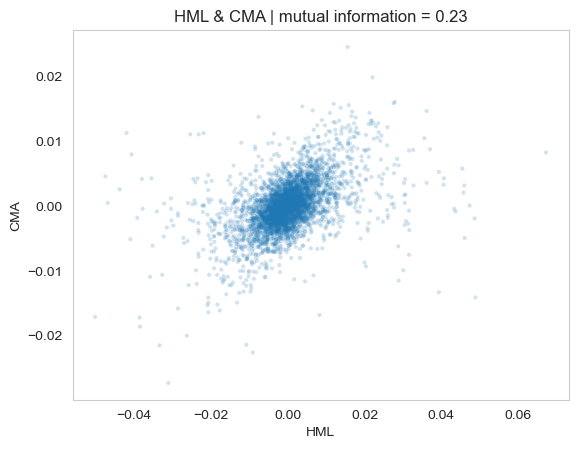

In [14]:
plt.scatter(
    factors['HML'], 
    factors['CMA'], 
    alpha = 0.2, 
    edgecolors = 'none', 
    marker = '.'
)
plt.xlabel('HML')
plt.ylabel('CMA')
plt.title('HML & CMA | mutual information = 0.23')
plt.show()

In [15]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
y = excess_return

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

#### Ordinary Least Squares

In [16]:
ols = sm.OLS(y_train, X_train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     740.3
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        03:04:34   Log-Likelihood:                 10141.
No. Observations:                3221   AIC:                        -2.027e+04
Df Residuals:                    3215   BIC:                        -2.023e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -2.204      0.0

In [17]:
y_pred = ols.predict(X_test)
y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = ['IBM'])

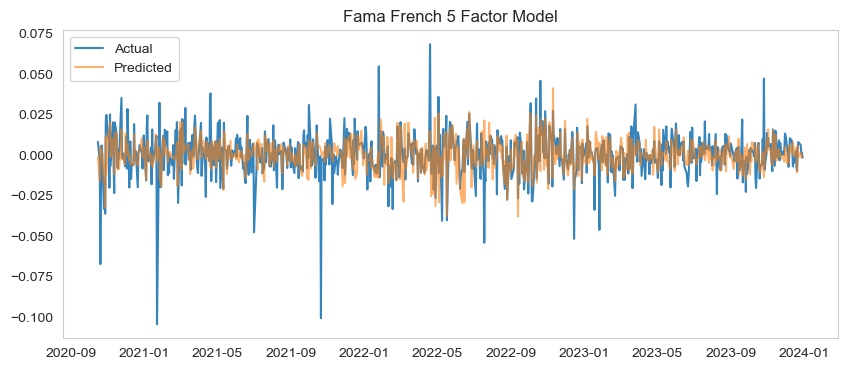

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.plot(y_test, label = 'Actual', alpha = 0.9)
plt.plot(y_pred, label = 'Predicted', alpha = 0.6)
plt.legend()
plt.title('Fama French 5 Factor Model')
plt.show()

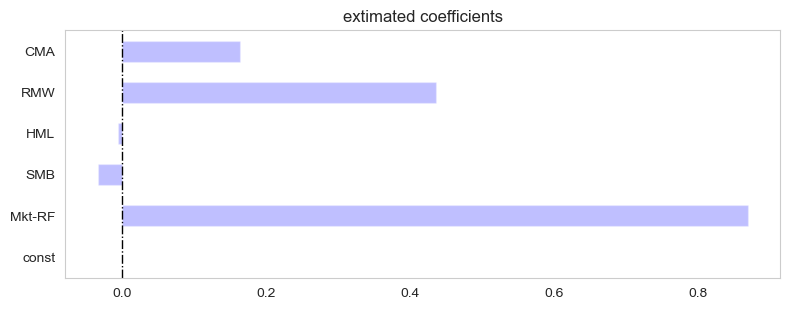

In [19]:
plt.figure(figsize = (8, 3))
plt.barh(
    ols.params.index, 
    ols.params, 
    color = 'b', 
    alpha = 0.25, 
    height = 0.5
)
plt.tight_layout()
plt.title('extimated coefficients')
plt.axvline(0, color = 'k', linestyle = '-.', linewidth = 1)
plt.show()

#### Penalized Regression

In [20]:
elastic = sm.OLS(y_train, X_train).fit_regularized(
    method = 'elastic_net',
    L1_wt = 0.01
)

In [21]:
elastic.params

const    -0.000404
Mkt-RF    0.868576
SMB      -0.034340
HML      -0.005674
RMW       0.435621
CMA       0.162874
dtype: float64

In [22]:
y_pred_elastic = ols.predict(X_test)
y_pred_elastic = pd.DataFrame(y_pred_elastic, index = y_test.index, columns = ['IBM'])
y_pred_elastic

,IBM
Date,
2020-10-16,-0.001254
2020-10-19,-0.015747
2020-10-20,0.005181
2020-10-21,-0.001101
2020-10-22,0.002373
...,...
2023-12-22,-0.001274
2023-12-26,0.001735
2023-12-27,-0.000655


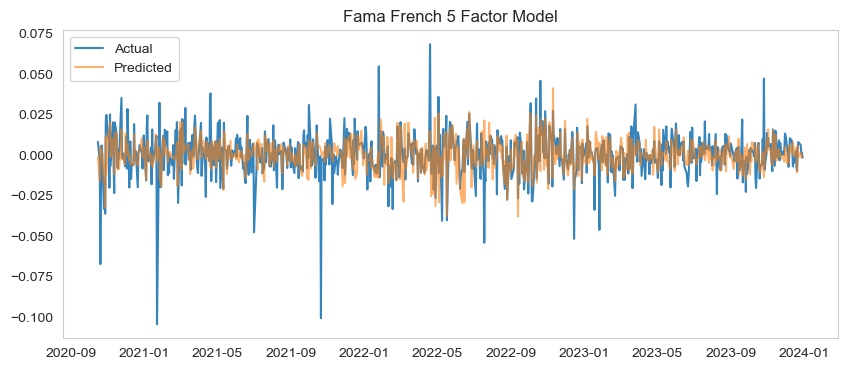

In [23]:
plt.figure(figsize = (10, 4))
plt.plot(y_test, label = 'Actual', alpha = 0.9)
plt.plot(y_pred_elastic, label = 'Predicted', alpha = 0.6)
plt.legend()
plt.title('Fama French 5 Factor Model')
plt.show()

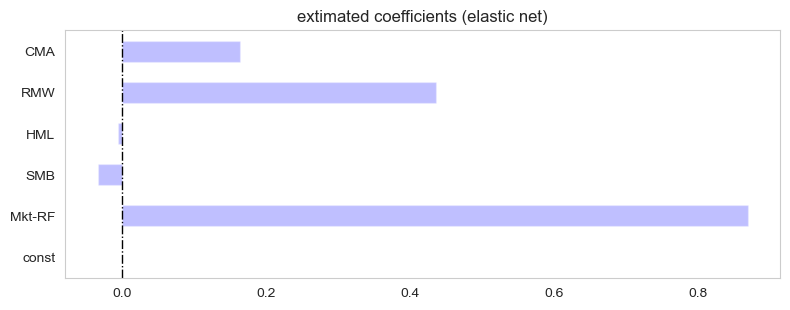

In [24]:
plt.figure(figsize = (8, 3))
plt.barh(
    elastic.params.index, 
    elastic.params, 
    color = 'b', 
    alpha = 0.25, 
    height = 0.5
)
plt.tight_layout()
plt.title('extimated coefficients (elastic net)')
plt.axvline(0, color = 'k', linestyle = '-.', linewidth = 1)
plt.show()

#### Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators = 1000, 
    criterion = 'squared_error',
    random_state = 42
)
forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [26]:
y_pred_forest = forest.predict(X_test)
y_pred_forest = pd.DataFrame(y_pred_forest, index = y_test.index, columns = ['IBM'])

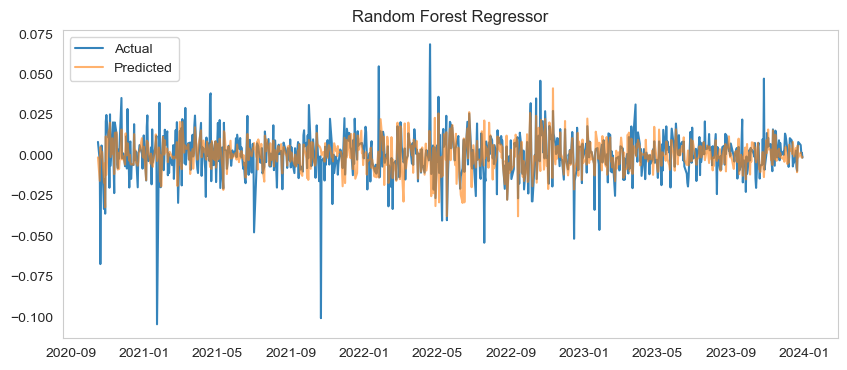

In [27]:
plt.figure(figsize = (10, 4))
plt.plot(y_test, label = 'Actual', alpha = 0.9)
plt.plot(y_pred, label = 'Predicted', alpha = 0.6)
plt.legend()
plt.title('Random Forest Regressor')
plt.show()

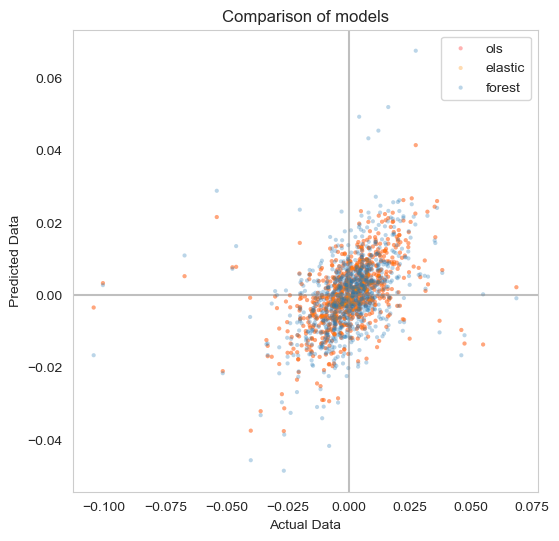

In [28]:
plt.figure(figsize = (6, 6))
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(y_test, y_pred, label = 'ols', marker = '.', color = 'red', alpha = 0.3, edgecolors = 'none')
plt.scatter(y_test, y_pred_elastic, label = 'elastic', marker = '.', color = 'darkorange', alpha = 0.3, edgecolors = 'none')
plt.scatter(y_test, y_pred_forest, label = 'forest', marker = '.', alpha = 0.3, edgecolors = 'none')
plt.legend()
plt.grid(False)
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.title('Comparison of models')
plt.show()

In [29]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, 
    X_test, 
    y_test, 
    n_repeats = 100, 
    random_state = 42
)

In [30]:
importance = pd.DataFrame(
    result.importances_mean, 
    index = X_test.columns, 
    columns = ['Importance']
)
importance = importance.sort_values(by = 'Importance', ascending = False)
importance

,Importance
Mkt-RF,0.730016
RMW,0.129743
CMA,0.080179
HML,0.046653
SMB,0.001469
const,0.000000


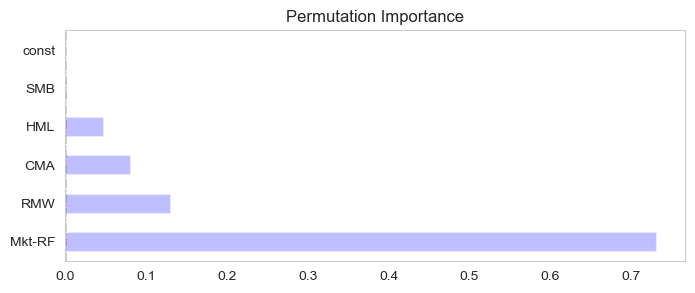

In [31]:
plt.figure(figsize = (8, 3))
plt.barh(
    importance.index, 
    importance['Importance'], 
    color = 'b', 
    alpha = 0.25, 
    height = 0.5
)
plt.axvline(0, color = 'k', linestyle = '-.', linewidth = 1)
plt.title('Permutation Importance')
plt.show()

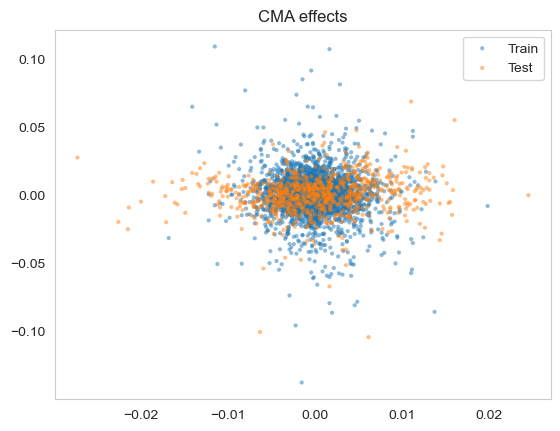

In [32]:
plt.scatter(X_train['CMA'], y_train, label = 'Train', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.scatter(X_test['CMA'], y_test, label = 'Test', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.legend()
plt.title('CMA effects')
plt.show()

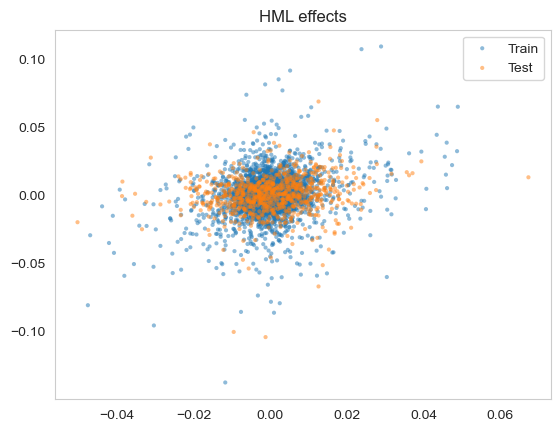

In [33]:
plt.scatter(X_train['HML'], y_train, label = 'Train', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.scatter(X_test['HML'], y_test, label = 'Test', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.legend()
plt.title('HML effects')
plt.show()

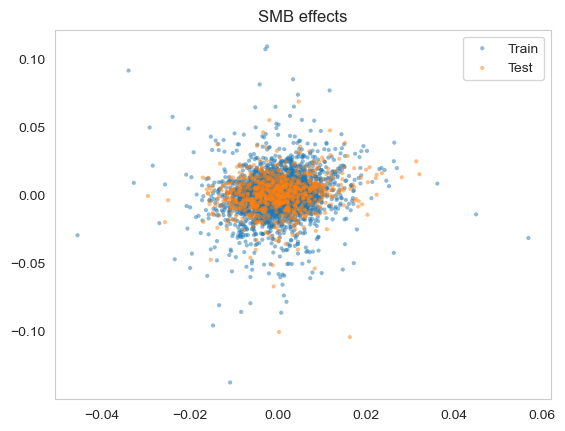

In [34]:
plt.scatter(X_train['SMB'], y_train, label = 'Train', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.scatter(X_test['SMB'], y_test, label = 'Test', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.legend()
plt.title('SMB effects')
plt.show()

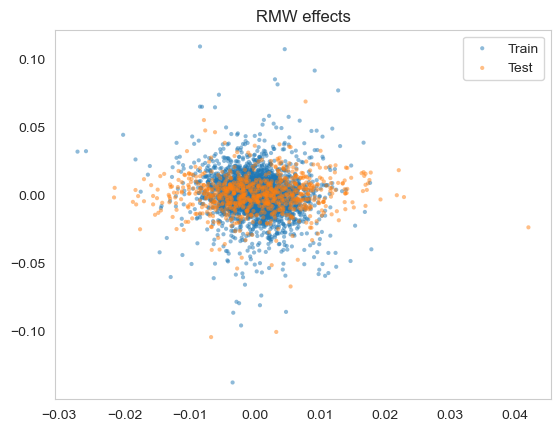

In [35]:
plt.scatter(X_train['RMW'], y_train, label = 'Train', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.scatter(X_test['RMW'], y_test, label = 'Test', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.legend()
plt.title('RMW effects')
plt.show()

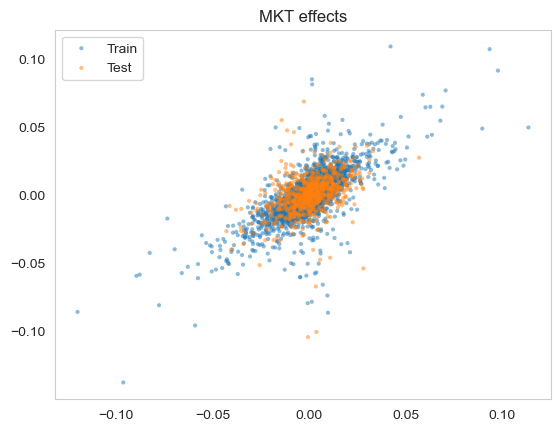

In [36]:
plt.scatter(X_train['Mkt-RF'], y_train, label = 'Train', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.scatter(X_test['Mkt-RF'], y_test, label = 'Test', marker = '.', alpha = 0.5, edgecolors = 'none')
plt.legend()
plt.title('MKT effects')
plt.show()

#### Double Machine Learning

OLS와 비슷한 결과를 도출하는가?

**HML**

In [37]:
from econml.dml import LinearDML

dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

In [38]:
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'SMB', 'RMW', 'CMA', 'Mkt-RF']], 
    X['HML'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [39]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.09670856286491246


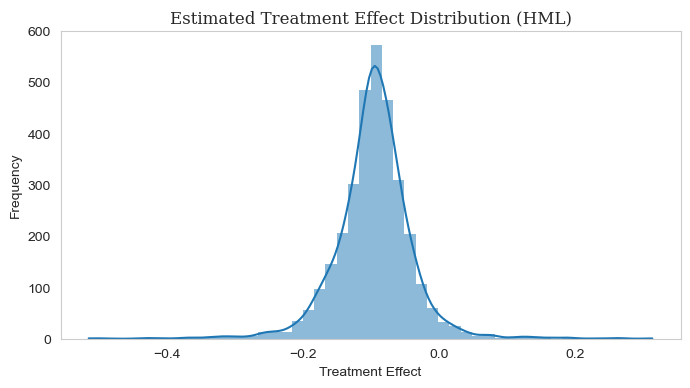

In [40]:
import seaborn as sns

plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (HML)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

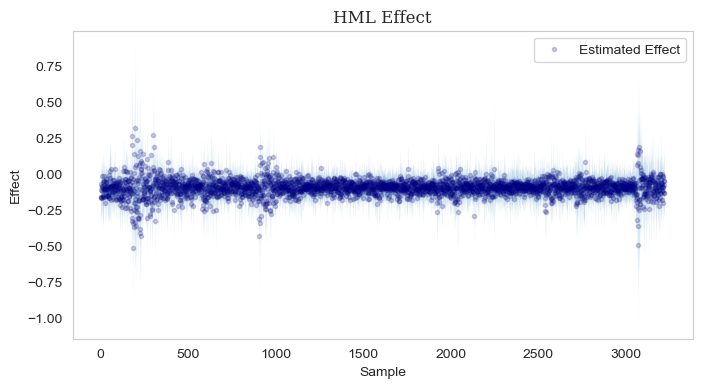

In [41]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.4)
plt.scatter(range(len(X_train)), treatment_effect, label='Estimated Effect', marker = '.', color = 'navy', alpha = 0.2)
plt.title('HML Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [42]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.0984398784621961


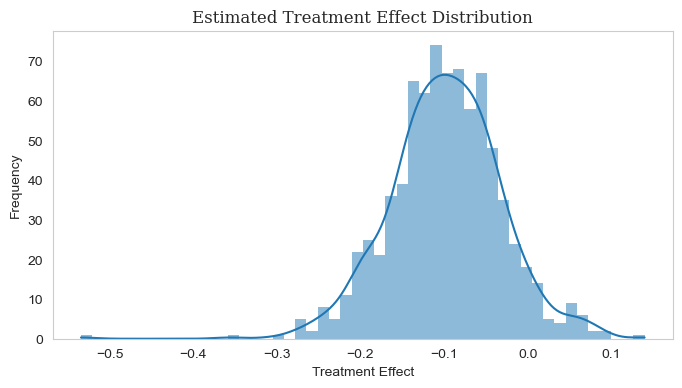

In [43]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

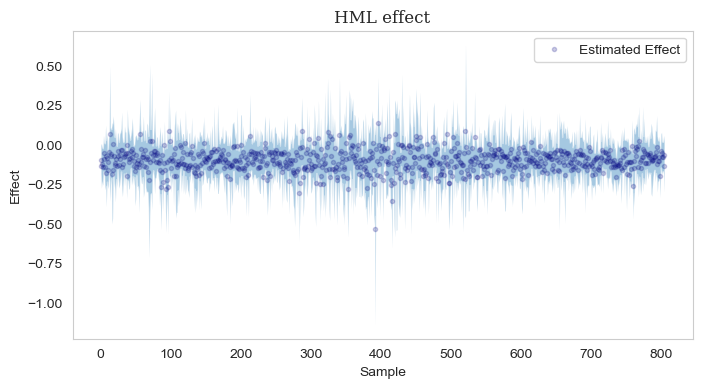

In [39]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.4)
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'navy', alpha = 0.2)
plt.title('HML effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

**SMB**

In [40]:
dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'HML', 'RMW', 'CMA', 'Mkt-RF']], 
    X['SMB'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [41]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.006640712563990153


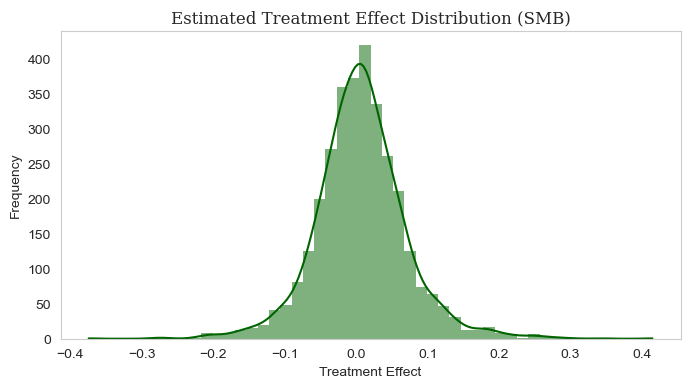

In [42]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkgreen')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (SMB)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

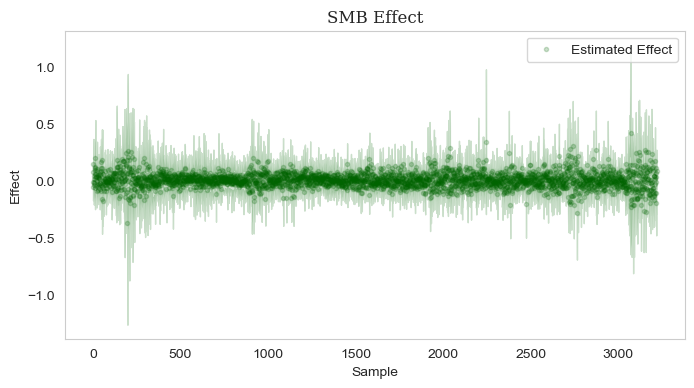

In [43]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkgreen')
plt.scatter(range(len(X_train)), treatment_effect, label = 'Estimated Effect', marker = '.', color = 'darkgreen', alpha = 0.2)
plt.title('SMB Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [44]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: 0.012985330892762815


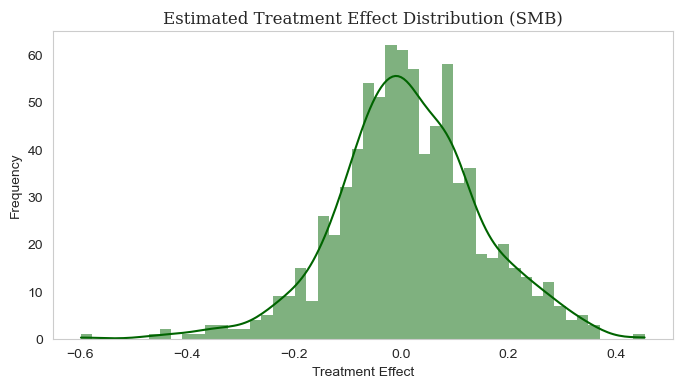

In [45]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkgreen')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (SMB)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

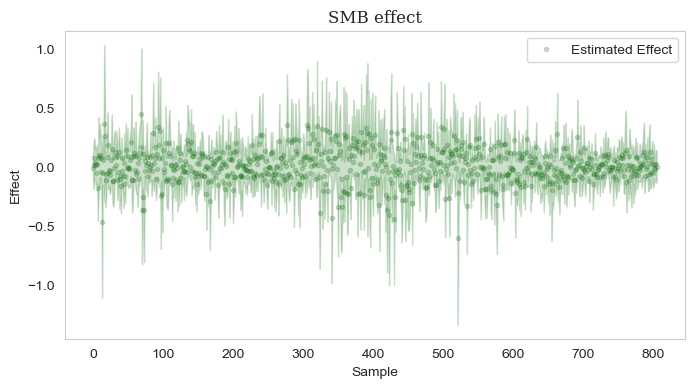

In [46]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkgreen')
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'darkgreen', alpha = 0.2)
plt.title('SMB effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

**RMW**

In [38]:
dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'HML', 'SMB', 'CMA']], 
    X['RMW'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [39]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.7477296909779182


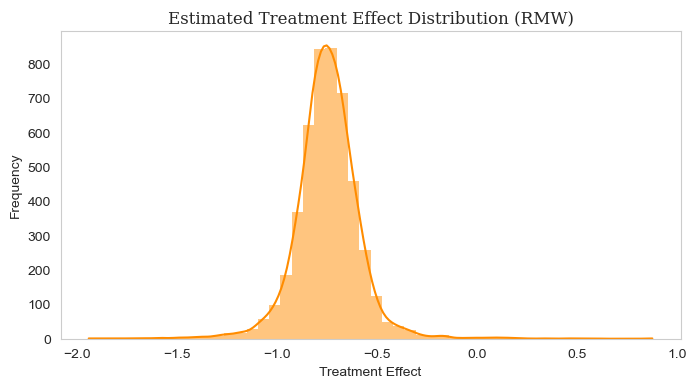

In [40]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkorange')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (RMW)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

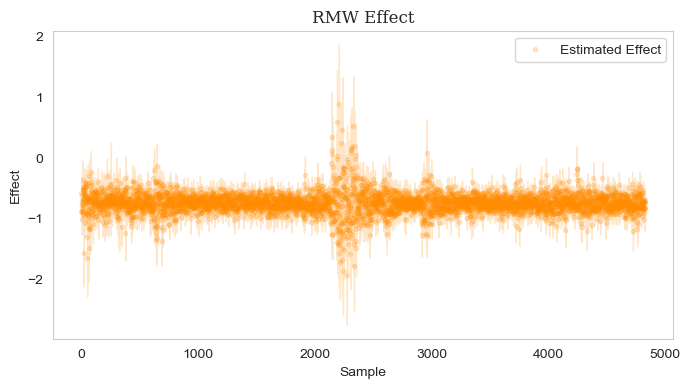

In [41]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkorange')
plt.scatter(range(len(X_train)), treatment_effect, label = 'Estimated Effect', marker = '.', color = 'darkorange', alpha = 0.2)
plt.title('RMW Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [42]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.7525667742702153


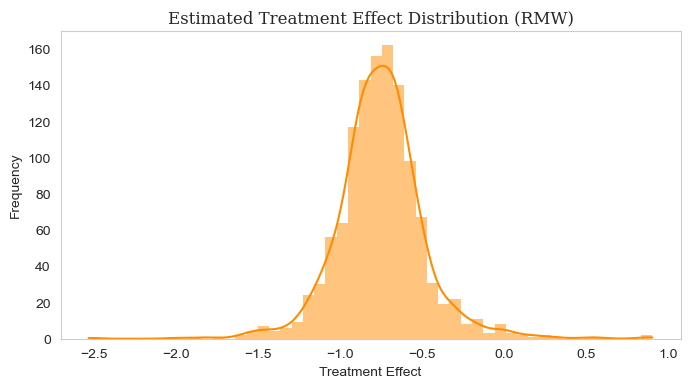

In [43]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'darkorange')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (RMW)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

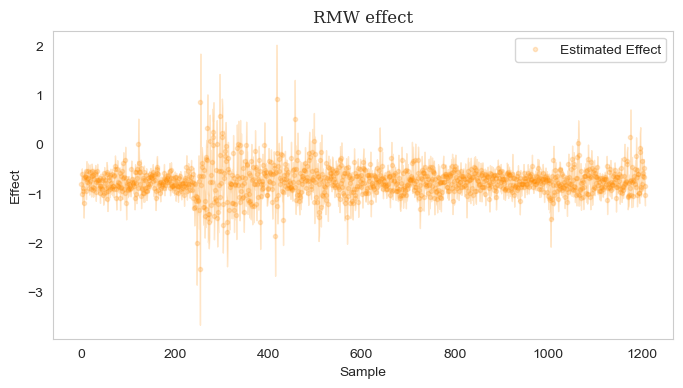

In [44]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'darkorange')
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'darkorange', alpha = 0.2)
plt.title('RMW effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

**CMA**

In [45]:
dml_model = LinearDML(
    model_y = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    model_t = RandomForestRegressor(
        n_estimators = 1000, 
        criterion = 'squared_error', 
        random_state = 42
    ), 
    random_state = 42
)

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(
    X[['const', 'HML', 'RMW', 'SMB']], 
    X['CMA'], 
    y, 
    test_size = 0.2, 
    shuffle = False
)

In [46]:
dml_model.fit(Y = y_train, 
              T = T_train, 
              X = X_train)

treatment_effect = dml_model.effect(X_train)

print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.5086477616759286


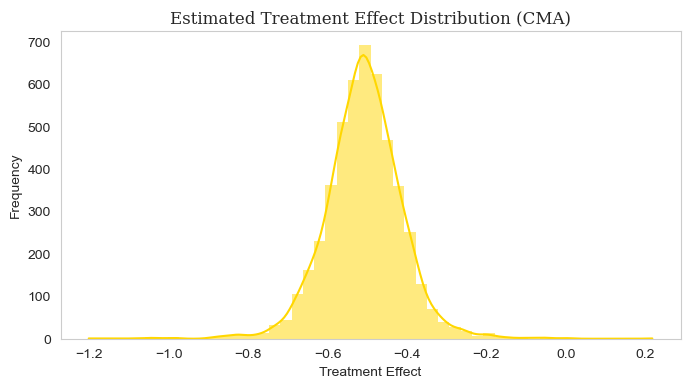

In [47]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'gold')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (CMA)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

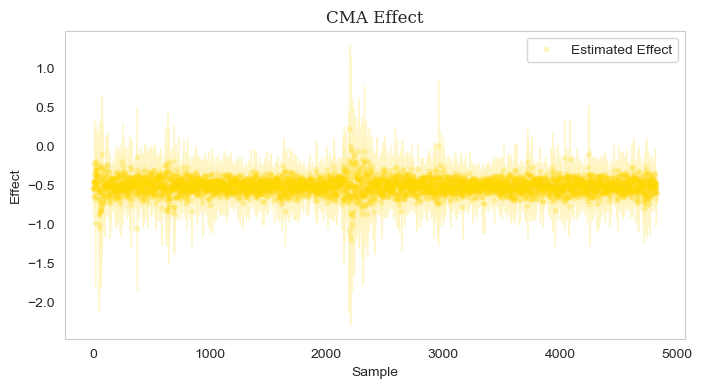

In [48]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_train)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_train)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'gold')
plt.scatter(range(len(X_train)), treatment_effect, label = 'Estimated Effect', marker = '.', color = 'gold', alpha = 0.2)
plt.title('CMA Effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()

In [49]:
treatment_effect = dml_model.effect(X_test)
print("Average Treatment Effect:", np.mean(treatment_effect))

Average Treatment Effect: -0.5104300974660719


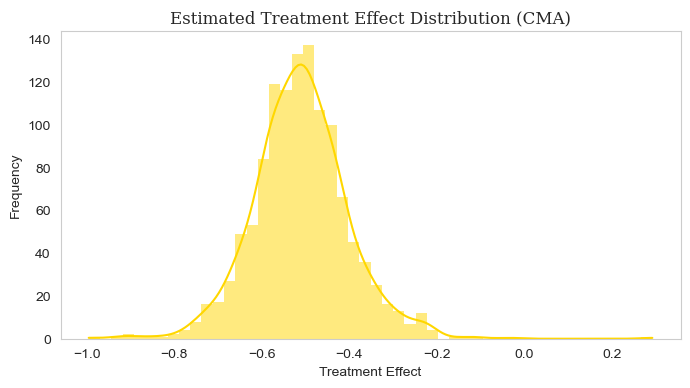

In [50]:
plt.figure(figsize = (8,4))
sns.histplot(treatment_effect, kde=True, bins = 50, edgecolor = 'None', color = 'gold')
plt.grid(False)
plt.title('Estimated Treatment Effect Distribution (CMA)', fontsize = 12, fontfamily = 'Serif')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()

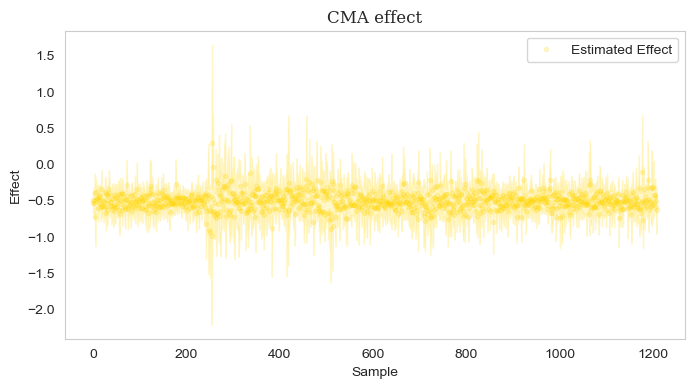

In [51]:
treatment_effect_lower, treatment_effect_upper = dml_model.effect_interval(X_test)
plt.figure(figsize = (8,4))
plt.fill_between(range(len(X_test)), treatment_effect_lower, treatment_effect_upper, alpha = 0.2, color = 'gold')
plt.scatter(range(len(X_test)), treatment_effect, label='Estimated Effect', marker = '.', color = 'gold', alpha = 0.2)
plt.title('CMA effect', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.xlabel('Sample')
plt.ylabel('Effect')
plt.legend()
plt.show()